# Supervised Learning notebook

This notebook will be for finding inferences on the given obesity dataset with supervised learning algorithms.

The goal will be to see if the feature variables can predict the correct obesity classification reliably.

##  Data Preparation

#### Initial import and data check

In [1]:
# initial imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Set random seed
np.random.seed(13)   # unlucky for some

In [2]:
# import obesity data
obesity_df = pd.read_csv("assignment_dataset/ObesityDataSet_raw_and_data_sinthetic.csv")

#### Redo ordinal targets and X dataset

In [3]:
# Ordinal target mapping for 7 obesity levels
obesity_map = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

# Create encoded target
y = obesity_df['NObeyesdad'].map(obesity_map)

# Reverse mapping for later visualisation. Swap k and v pairs.
reverse_map = {v: k for k, v in obesity_map.items()}

In [4]:
# Separate features from target
X = obesity_df.drop('NObeyesdad', axis=1)

#### Train test split stratified

In [5]:
# Stratified train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=13,    # unlucky for some
    stratify=y  # keeps classes even
)

#### Feature encoding

Rather than do individual cells, do it all as a function?

In [6]:
# define groups
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
binary_features = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
ordinal_features = ['CAEC', 'CALC']
nominal_features = ['Gender', 'MTRANS']

In [7]:
# function to encode features
def encode_features(df):
    """Apply encoding to feature dataframe"""
    df_enc = df.copy()

    # binary = yes/no -> 1/0
    for col in binary_features:
        df_enc[col] = (df_enc[col] == 'yes').astype(int)

    # ordinal =  map to 0/1/2/3
    ordinal_mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
    for col in ordinal_features:
        df_enc[col] = df_enc[col].map(ordinal_mapping)

    # nominal = one-hot encode (drop_first=True)
    df_enc = pd.get_dummies(df_enc, columns=nominal_features, drop_first=True)

    return df_enc

In [8]:
# Apply encoding to train and test
X_train_enc = encode_features(X_train)
X_test_enc = encode_features(X_test)

In [9]:
X_train_enc

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Gender_Male,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
1063,45.000000,1.675953,79.668320,1,1,2.598051,3.000000,1,0,1.000000,0,0.000000,0.000000,0,False,False,False,False,False
118,23.000000,1.620000,53.000000,1,1,2.000000,3.000000,1,0,2.000000,0,1.000000,1.000000,1,True,False,False,True,False
877,18.000000,1.647971,68.818893,1,1,2.000000,1.411685,1,0,1.859089,0,0.000000,1.306000,0,False,False,False,True,False
480,18.000000,1.570000,50.000000,0,1,2.000000,3.000000,1,0,1.000000,0,0.000000,1.000000,1,False,False,False,True,False
447,19.000000,1.800000,87.000000,1,1,2.000000,4.000000,1,0,2.000000,0,2.000000,1.000000,1,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,30.475248,1.801368,121.094257,1,1,2.328469,3.000000,1,0,2.001208,0,0.800487,0.176678,1,True,False,False,False,False
541,19.717249,1.688426,49.660995,0,0,2.714447,3.000000,2,0,2.000000,0,1.903182,1.000000,1,False,False,False,True,False
1317,24.184891,1.768834,97.449743,1,1,2.000000,3.000000,1,0,2.973729,0,2.491642,1.365950,0,True,False,False,True,False
1035,17.971574,1.720379,85.000000,1,1,2.000000,3.000000,1,0,2.802498,0,1.000000,0.417580,1,True,False,False,True,False


In [10]:
X_test_enc

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Gender_Male,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
743,18.381382,1.722547,53.783977,1,1,2.000000,3.131032,1,0,2.072194,0,1.487987,2.000000,1,True,False,False,True,False
280,21.000000,1.750000,62.000000,0,1,3.000000,4.000000,2,1,2.000000,0,0.000000,0.000000,1,True,False,False,True,False
261,28.000000,1.700000,73.000000,1,0,2.000000,3.000000,2,0,2.000000,1,2.000000,0.000000,1,False,False,False,False,True
1983,20.908785,1.700996,126.490236,1,1,3.000000,3.000000,1,0,1.242832,0,0.530925,0.575969,1,False,False,False,True,False
85,23.000000,1.650000,58.500000,1,0,2.000000,3.000000,1,0,2.000000,0,0.000000,0.000000,0,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,18.000000,1.750000,85.000000,1,0,2.000000,3.000000,1,0,3.000000,0,1.000000,0.000000,1,True,False,False,True,False
1083,24.122589,1.856759,95.887056,1,1,1.116068,2.449067,1,0,2.000000,0,0.926350,1.971170,1,True,False,False,True,False
967,32.278869,1.646020,74.147443,1,1,2.885178,2.562895,1,0,1.017006,0,0.588673,0.916291,1,False,False,False,False,False
1560,25.300208,1.765258,114.330023,1,1,1.562804,3.000000,1,0,2.075493,0,1.553734,0.000436,1,True,False,False,True,False


Encoding looks good, although I see warnings for duplicate rows. 16 (1%) in training set and 4 (0.8%) in test set.

#### Scale the features

To stop data leaking we fit and trasnform on the training set and only transform on the test set.

In [11]:
# Set up standard scaler
scaler = StandardScaler()

In [12]:
# Fit and transform on training set, ONLY transform on test set
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [13]:
# convert back to dataframes to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_enc.columns, index=X_train_enc.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_enc.columns, index=X_test_enc.index)

In [14]:
print(X_train_scaled.mean().mean())   # should be 0
print(X_train_scaled.std().mean())   # should be 1

8.937300885136249e-17
1.0003160056959908


In [15]:
print(X_test_scaled.mean().mean())   # should be 0 or very near it
print(X_test_scaled.std().mean())   # should be 1 or very near it

0.010287451224926508
0.9820207470168661


## Logistic Regression

Logistic regression is promising for ordinal targets. Let's try that first.

#### Training

In [21]:
# Automatically multiclassify with LogisticRegression
log_reg = LogisticRegression(
    solver='lbfgs',
    max_iter=100,   # make sure model converges
    random_state=13,
    C=1.0
)

# Train the model
log_reg.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",13
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [22]:
# Check convergence
print(log_reg.n_iter_[0])
print(log_reg.classes_)  # should be [0, 1, 2, 3, 4, 5, 6]
print(log_reg.coef_.shape)  # should 7 * 19

70
[0 1 2 3 4 5 6]
(7, 19)


#### Testing / Performance

In [23]:
# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Get prediction probabilities
y_test_proba = log_reg.predict_proba(X_test_scaled)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [24]:
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Difference: {abs(train_accuracy - test_accuracy):.4f}")

LOGISTIC REGRESSION PERFORMANCE
Training Accuracy: 0.8983 (89.83%)
Test Accuracy:     0.8750 (87.50%)
Difference:        0.0233

✓ Good generalisation


In [25]:
# Generate classification report
target_names = [reverse_map[i] for i in sorted(reverse_map.keys())]

print(classification_report(y_test, y_test_pred, target_names=target_names, digits=3))

                     precision    recall  f1-score   support

Insufficient_Weight      0.904     0.971     0.936        68
      Normal_Weight      0.855     0.736     0.791        72
 Overweight_Level_I      0.732     0.822     0.774        73
Overweight_Level_II      0.790     0.681     0.731        72
     Obesity_Type_I      0.890     0.920     0.905        88
    Obesity_Type_II      0.936     0.986     0.961        74
   Obesity_Type_III      1.000     0.988     0.994        81

           accuracy                          0.875       528
          macro avg      0.872     0.872     0.870       528
       weighted avg      0.875     0.875     0.873       528


Weighted F1-Score: 0.8731
Macro F1-Score: 0.8703


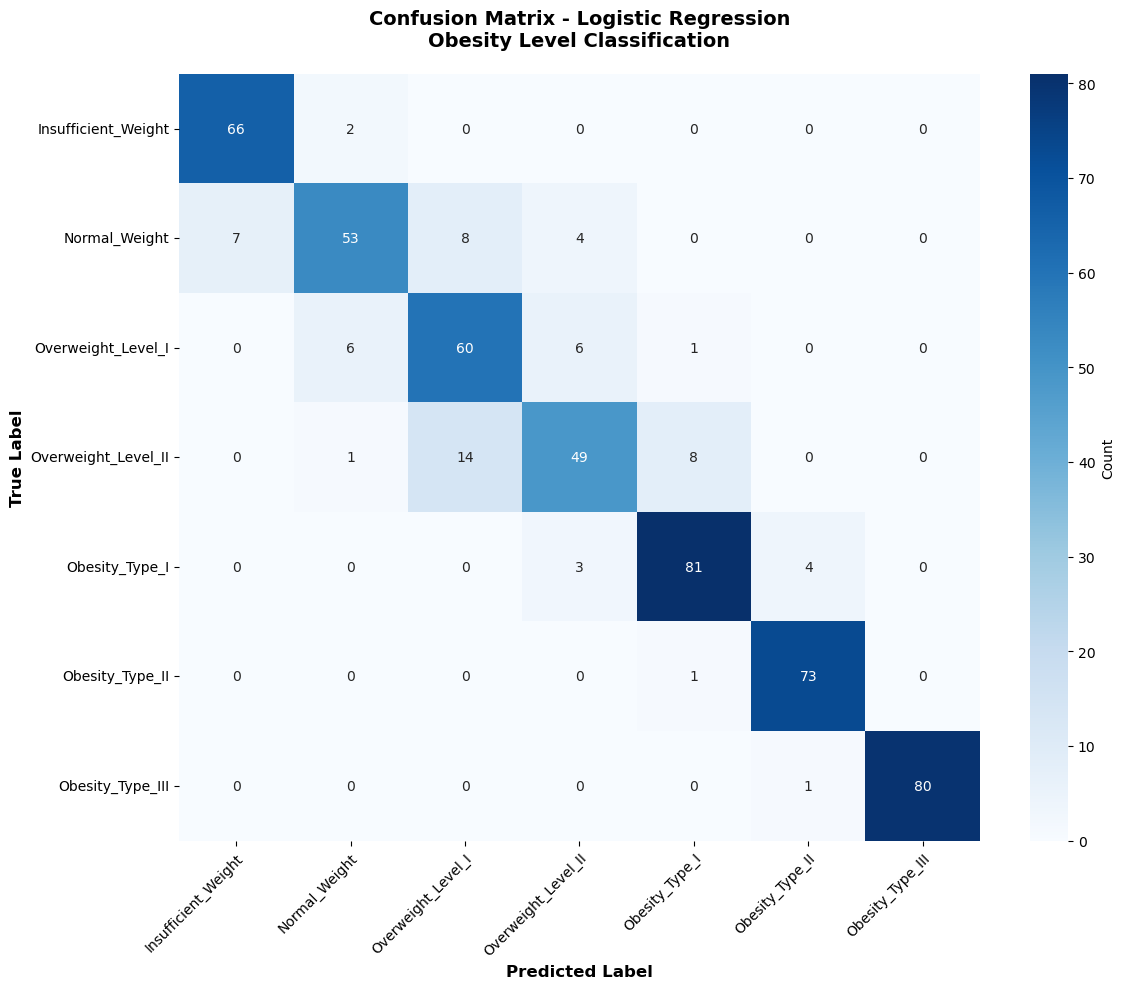

In [26]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create visualisation
fig, ax = plt.subplots(figsize=(12, 10))

# Plot heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    cbar_kws={'label': 'Count'},
    ax=ax
)

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Logistic Regression\nObesity Level Classification',
             fontsize=14, fontweight='bold', pad=20)

# Rotate labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()